In [1]:
import json
import re
from collections import defaultdict
from transformers import pipeline
import pandas as pd
import torch
import warnings
from datasets import Dataset
import matplotlib.pyplot as plt
from tabulate import tabulate
from difflib import SequenceMatcher

c:\Users\feder\Desktop\SMMproject\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device")

NVIDIA GeForce RTX 2060 SUPER


In [3]:
INPUT_PATH = "commenti_associabili.json"

soggetti = {
    "stefania": ["stefania", "stefania cappa"],
    "paola": ["paola", "paola cappa"],
    "andrea": ["andrea", "andrea sempio", "sempio"],
    "alberto": ["alberto", "alberto stasi", "stasi"],
    "marco": ["marco", "marco poggi"],
    "stefania e paola": ["stefania cappa e paola cappa", "stefania e paola", "gemelle cappa", "gemelle", "sorelle"],
}

genere_soggetti = {
    "stefania": "femminile",
    "paola": "femminile",
    "andrea": "maschile",
    "alberto": "maschile",
    "marco": "maschile",
    "stefania e paola": "femminile",
}

In [4]:
def pulisci_testo(testo):
    testo = testo.lower()
    testo = re.sub(r"http\S+", "", testo)
    testo = re.sub(r"@\w+", "", testo)
    testo = re.sub(r"[^a-zA-Zàèéìòùç0-9\s']", " ", testo)
    testo = re.sub(r"\s+", " ", testo)
    return testo.strip()

parole_vaghe = ["mah", "boh", "non lo so", "assurdo", "incredibile", "chissà"]

def commento_valido(testo):
    parole = testo.split()
    if len(parole) < 4:
        return False
    if len(parole) > 100: 
        return False
    if any(vaga in testo for vaga in parole_vaghe):
        return False
    return True

def trova_soggetto(testo):
    for soggetto, varianti in soggetti.items():
        for v in varianti:
            if v in testo:
                return soggetto
            if SequenceMatcher(None, v, testo).ratio() > 0.88:
                return soggetto
    return None

In [5]:
with open(INPUT_PATH, "r", encoding="utf-8") as f:
    all_comments = json.load(f)

In [6]:
warnings.filterwarnings("ignore", category=UserWarning, module="torch.utils.data.dataloader")

classifier = pipeline(
    "zero-shot-classification",
    model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli",
    device=0,
    truncation=True
)

etichette = ["colpevole", "innocente", "neutro"]
templates = [
    "Secondo questo commento, il soggetto è {}.",
    "Il soggetto viene visto come {}."
]

texts = []
matched_subjects = []
dates = []
original_comments = []
genres = []

for c in all_comments:
    testo_pulito = pulisci_testo(c["content"])
    if not commento_valido(testo_pulito):
        continue
    soggetto_trovato = trova_soggetto(testo_pulito)
    if soggetto_trovato:
        texts.append(c["content"])
        matched_subjects.append(soggetto_trovato)
        dates.append(c["date"])
        original_comments.append(c["content"])
        genres.append(genere_soggetti[soggetto_trovato])

dataset = Dataset.from_dict({
    "text": texts,
    "subject": matched_subjects,
    "genre": genres,
    "date": dates,
    "original_comment": original_comments,
})

giudizi = defaultdict(lambda: {"colpevole": 0, "innocente": 0, "neutro": 0})
giudizi_per_genere = defaultdict(lambda: {"colpevole": 0, "innocente": 0, "neutro": 0})
dettagli = []

total = len(dataset)
print(f"Commenti da classificare: {total}")
total_classified = 0

def classify_batch(batch):
    global total_classified
    num_samples = len(batch["text"])

    # Inizializza i punteggi per ogni riga
    scores_batch = [defaultdict(float) for _ in range(num_samples)]

    # Applica ogni template al batch intero
    for template in templates:
        outputs = classifier(
            batch["text"],
            candidate_labels=etichette,
            hypothesis_template=template,
            multi_label=False
        )
        for i, output in enumerate(outputs):
            for label, score in zip(output["labels"], output["scores"]):
                scores_batch[i][label] += score

    # Finalizza le predizioni
    pred_labels = []
    for votes in scores_batch:
        total_score = sum(votes.values())
        max_label, max_score = max(votes.items(), key=lambda x: x[1])
        conf_percent = max_score / total_score if total_score > 0 else 0

        if conf_percent < 0.40:
            pred_labels.append("neutro")
        else:
            pred_labels.append(max_label)

    total_classified += num_samples
    print(f"Classificati {total_classified}/{total} ({total_classified / total * 100:.2f}%) commenti...")
    return {"pred_label": pred_labels}

results = dataset.map(
    classify_batch,
    batched=True,
    batch_size=64,
)

for i in range(len(results)):
    soggetto = results[i]["subject"]
    genere = results[i]["genre"]
    label = results[i]["pred_label"]
    giudizi[soggetto][label] += 1
    giudizi_per_genere[genere][label] += 1
    dettagli.append({
        "soggetto": soggetto,
        "genere": genere,
        "data": results[i]["date"],
        "giudizio": label,
        "commento": results[i]["original_comment"],
    })

print("Classificazione completata.")

output_data = {
    "giudizi_per_soggetto": giudizi,
    "giudizi_per_genere": giudizi_per_genere,
    "dettagli_commenti": dettagli
}

with open("giudizi.json", "w", encoding="utf-8") as f:
    json.dump(output_data, f, ensure_ascii=False, indent=2)

pd.DataFrame(dettagli).to_csv("dettagli_commenti.csv", index=False)
print('Risultati salvati in "giudizi.json" e "dettagli_commenti.csv"')

Commenti da classificare: 12471


Map:   1%|          | 64/12471 [00:07<23:29,  8.80 examples/s]

Classificati 64/12471 (0.51%) commenti...


Map:   1%|          | 128/12471 [00:14<23:10,  8.87 examples/s]

Classificati 128/12471 (1.03%) commenti...


Map:   2%|▏         | 192/12471 [00:21<23:00,  8.89 examples/s]

Classificati 192/12471 (1.54%) commenti...


Map:   2%|▏         | 256/12471 [00:28<22:54,  8.89 examples/s]

Classificati 256/12471 (2.05%) commenti...


Map:   3%|▎         | 320/12471 [00:35<22:37,  8.95 examples/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Classificati 320/12471 (2.57%) commenti...


Map:   3%|▎         | 384/12471 [00:42<22:16,  9.04 examples/s]

Classificati 384/12471 (3.08%) commenti...


Map:   4%|▎         | 448/12471 [00:49<22:13,  9.02 examples/s]

Classificati 448/12471 (3.59%) commenti...


Map:   4%|▍         | 512/12471 [00:57<22:03,  9.04 examples/s]

Classificati 512/12471 (4.11%) commenti...


Map:   5%|▍         | 576/12471 [01:04<21:52,  9.06 examples/s]

Classificati 576/12471 (4.62%) commenti...


Map:   5%|▌         | 640/12471 [01:11<21:45,  9.06 examples/s]

Classificati 640/12471 (5.13%) commenti...


Map:   6%|▌         | 704/12471 [01:18<21:37,  9.07 examples/s]

Classificati 704/12471 (5.65%) commenti...


Map:   6%|▌         | 768/12471 [01:25<21:37,  9.02 examples/s]

Classificati 768/12471 (6.16%) commenti...


Map:   7%|▋         | 832/12471 [01:32<21:25,  9.05 examples/s]

Classificati 832/12471 (6.67%) commenti...


Map:   7%|▋         | 896/12471 [01:39<21:11,  9.10 examples/s]

Classificati 896/12471 (7.18%) commenti...


Map:   8%|▊         | 960/12471 [01:46<21:03,  9.11 examples/s]

Classificati 960/12471 (7.70%) commenti...


Map:   8%|▊         | 1024/12471 [01:53<20:59,  9.09 examples/s]

Classificati 1024/12471 (8.21%) commenti...


Map:   9%|▊         | 1088/12471 [02:00<20:51,  9.10 examples/s]

Classificati 1088/12471 (8.72%) commenti...


Map:   9%|▉         | 1152/12471 [02:07<20:46,  9.08 examples/s]

Classificati 1152/12471 (9.24%) commenti...


Map:  10%|▉         | 1216/12471 [02:14<20:33,  9.12 examples/s]

Classificati 1216/12471 (9.75%) commenti...


Map:  10%|█         | 1280/12471 [02:21<20:31,  9.09 examples/s]

Classificati 1280/12471 (10.26%) commenti...


Map:  11%|█         | 1344/12471 [02:28<20:31,  9.03 examples/s]

Classificati 1344/12471 (10.78%) commenti...


Map:  11%|█▏        | 1408/12471 [02:35<20:23,  9.04 examples/s]

Classificati 1408/12471 (11.29%) commenti...


Map:  12%|█▏        | 1472/12471 [02:42<20:16,  9.04 examples/s]

Classificati 1472/12471 (11.80%) commenti...


Map:  12%|█▏        | 1536/12471 [02:49<20:06,  9.06 examples/s]

Classificati 1536/12471 (12.32%) commenti...


Map:  13%|█▎        | 1600/12471 [02:56<19:54,  9.10 examples/s]

Classificati 1600/12471 (12.83%) commenti...


Map:  13%|█▎        | 1664/12471 [03:03<19:49,  9.09 examples/s]

Classificati 1664/12471 (13.34%) commenti...


Map:  14%|█▍        | 1728/12471 [03:10<19:41,  9.10 examples/s]

Classificati 1728/12471 (13.86%) commenti...


Map:  14%|█▍        | 1792/12471 [03:18<19:40,  9.04 examples/s]

Classificati 1792/12471 (14.37%) commenti...


Map:  15%|█▍        | 1856/12471 [03:25<19:30,  9.07 examples/s]

Classificati 1856/12471 (14.88%) commenti...


Map:  15%|█▌        | 1920/12471 [03:32<19:23,  9.07 examples/s]

Classificati 1920/12471 (15.40%) commenti...


Map:  16%|█▌        | 1984/12471 [03:39<19:15,  9.08 examples/s]

Classificati 1984/12471 (15.91%) commenti...


Map:  16%|█▋        | 2048/12471 [03:46<19:00,  9.14 examples/s]

Classificati 2048/12471 (16.42%) commenti...


Map:  17%|█▋        | 2112/12471 [03:53<18:53,  9.14 examples/s]

Classificati 2112/12471 (16.94%) commenti...


Map:  17%|█▋        | 2176/12471 [04:00<18:45,  9.14 examples/s]

Classificati 2176/12471 (17.45%) commenti...


Map:  18%|█▊        | 2240/12471 [04:07<18:39,  9.14 examples/s]

Classificati 2240/12471 (17.96%) commenti...


Map:  18%|█▊        | 2304/12471 [04:13<18:26,  9.19 examples/s]

Classificati 2304/12471 (18.47%) commenti...


Map:  19%|█▉        | 2368/12471 [04:20<18:20,  9.18 examples/s]

Classificati 2368/12471 (18.99%) commenti...


Map:  20%|█▉        | 2432/12471 [04:28<18:17,  9.15 examples/s]

Classificati 2432/12471 (19.50%) commenti...


Map:  20%|██        | 2496/12471 [04:34<18:09,  9.15 examples/s]

Classificati 2496/12471 (20.01%) commenti...


Map:  21%|██        | 2560/12471 [04:41<18:00,  9.18 examples/s]

Classificati 2560/12471 (20.53%) commenti...


Map:  21%|██        | 2624/12471 [04:48<17:53,  9.18 examples/s]

Classificati 2624/12471 (21.04%) commenti...


Map:  22%|██▏       | 2688/12471 [04:55<17:45,  9.18 examples/s]

Classificati 2688/12471 (21.55%) commenti...


Map:  22%|██▏       | 2752/12471 [05:02<17:37,  9.19 examples/s]

Classificati 2752/12471 (22.07%) commenti...


Map:  23%|██▎       | 2816/12471 [05:09<17:31,  9.18 examples/s]

Classificati 2816/12471 (22.58%) commenti...


Map:  23%|██▎       | 2880/12471 [05:16<17:25,  9.18 examples/s]

Classificati 2880/12471 (23.09%) commenti...


Map:  24%|██▎       | 2944/12471 [05:23<17:18,  9.17 examples/s]

Classificati 2944/12471 (23.61%) commenti...


Map:  24%|██▍       | 3008/12471 [05:30<17:20,  9.09 examples/s]

Classificati 3008/12471 (24.12%) commenti...


Map:  25%|██▍       | 3072/12471 [05:37<17:10,  9.12 examples/s]

Classificati 3072/12471 (24.63%) commenti...


Map:  25%|██▌       | 3136/12471 [05:44<17:02,  9.13 examples/s]

Classificati 3136/12471 (25.15%) commenti...


Map:  26%|██▌       | 3200/12471 [05:51<16:50,  9.18 examples/s]

Classificati 3200/12471 (25.66%) commenti...


Map:  26%|██▌       | 3264/12471 [05:58<16:42,  9.19 examples/s]

Classificati 3264/12471 (26.17%) commenti...


Map:  27%|██▋       | 3328/12471 [06:05<16:32,  9.21 examples/s]

Classificati 3328/12471 (26.69%) commenti...


Map:  27%|██▋       | 3392/12471 [06:12<16:25,  9.21 examples/s]

Classificati 3392/12471 (27.20%) commenti...


Map:  28%|██▊       | 3456/12471 [06:19<16:21,  9.19 examples/s]

Classificati 3456/12471 (27.71%) commenti...


Map:  28%|██▊       | 3520/12471 [06:26<16:24,  9.09 examples/s]

Classificati 3520/12471 (28.23%) commenti...


Map:  29%|██▊       | 3584/12471 [06:33<16:14,  9.12 examples/s]

Classificati 3584/12471 (28.74%) commenti...


Map:  29%|██▉       | 3648/12471 [06:40<16:05,  9.14 examples/s]

Classificati 3648/12471 (29.25%) commenti...


Map:  30%|██▉       | 3712/12471 [06:47<15:55,  9.17 examples/s]

Classificati 3712/12471 (29.77%) commenti...


Map:  30%|███       | 3776/12471 [06:54<15:45,  9.20 examples/s]

Classificati 3776/12471 (30.28%) commenti...


Map:  31%|███       | 3840/12471 [07:01<15:35,  9.22 examples/s]

Classificati 3840/12471 (30.79%) commenti...


Map:  31%|███▏      | 3904/12471 [07:08<15:30,  9.21 examples/s]

Classificati 3904/12471 (31.30%) commenti...


Map:  32%|███▏      | 3968/12471 [07:15<15:24,  9.19 examples/s]

Classificati 3968/12471 (31.82%) commenti...


Map:  32%|███▏      | 4032/12471 [07:22<15:16,  9.21 examples/s]

Classificati 4032/12471 (32.33%) commenti...


Map:  33%|███▎      | 4096/12471 [07:29<15:13,  9.16 examples/s]

Classificati 4096/12471 (32.84%) commenti...


Map:  33%|███▎      | 4160/12471 [07:36<15:08,  9.15 examples/s]

Classificati 4160/12471 (33.36%) commenti...


Map:  34%|███▍      | 4224/12471 [07:43<14:59,  9.17 examples/s]

Classificati 4224/12471 (33.87%) commenti...


Map:  34%|███▍      | 4288/12471 [07:50<14:51,  9.17 examples/s]

Classificati 4288/12471 (34.38%) commenti...


Map:  35%|███▍      | 4352/12471 [07:57<14:45,  9.17 examples/s]

Classificati 4352/12471 (34.90%) commenti...


Map:  35%|███▌      | 4416/12471 [08:04<14:35,  9.21 examples/s]

Classificati 4416/12471 (35.41%) commenti...


Map:  36%|███▌      | 4480/12471 [08:11<14:25,  9.24 examples/s]

Classificati 4480/12471 (35.92%) commenti...


Map:  36%|███▋      | 4544/12471 [08:18<14:22,  9.19 examples/s]

Classificati 4544/12471 (36.44%) commenti...


Map:  37%|███▋      | 4608/12471 [08:25<14:17,  9.17 examples/s]

Classificati 4608/12471 (36.95%) commenti...


Map:  37%|███▋      | 4672/12471 [08:32<14:14,  9.12 examples/s]

Classificati 4672/12471 (37.46%) commenti...


Map:  38%|███▊      | 4736/12471 [08:39<14:04,  9.16 examples/s]

Classificati 4736/12471 (37.98%) commenti...


Map:  38%|███▊      | 4800/12471 [08:46<13:57,  9.16 examples/s]

Classificati 4800/12471 (38.49%) commenti...


Map:  39%|███▉      | 4864/12471 [08:53<13:51,  9.15 examples/s]

Classificati 4864/12471 (39.00%) commenti...


Map:  40%|███▉      | 4928/12471 [09:00<13:55,  9.03 examples/s]

Classificati 4928/12471 (39.52%) commenti...


Map:  40%|████      | 4992/12471 [09:07<13:55,  8.95 examples/s]

Classificati 4992/12471 (40.03%) commenti...


Map:  41%|████      | 5056/12471 [09:14<13:41,  9.03 examples/s]

Classificati 5056/12471 (40.54%) commenti...


Map:  41%|████      | 5120/12471 [09:21<13:30,  9.07 examples/s]

Classificati 5120/12471 (41.06%) commenti...


Map:  42%|████▏     | 5184/12471 [09:28<13:26,  9.04 examples/s]

Classificati 5184/12471 (41.57%) commenti...


Map:  42%|████▏     | 5248/12471 [09:35<13:14,  9.09 examples/s]

Classificati 5248/12471 (42.08%) commenti...


Map:  43%|████▎     | 5312/12471 [09:42<13:04,  9.13 examples/s]

Classificati 5312/12471 (42.59%) commenti...


Map:  43%|████▎     | 5376/12471 [09:49<12:56,  9.14 examples/s]

Classificati 5376/12471 (43.11%) commenti...


Map:  44%|████▎     | 5440/12471 [09:56<12:45,  9.18 examples/s]

Classificati 5440/12471 (43.62%) commenti...


Map:  44%|████▍     | 5504/12471 [10:03<12:41,  9.14 examples/s]

Classificati 5504/12471 (44.13%) commenti...


Map:  45%|████▍     | 5568/12471 [10:10<12:31,  9.19 examples/s]

Classificati 5568/12471 (44.65%) commenti...


Map:  45%|████▌     | 5632/12471 [10:17<12:23,  9.20 examples/s]

Classificati 5632/12471 (45.16%) commenti...


Map:  46%|████▌     | 5696/12471 [10:24<12:16,  9.20 examples/s]

Classificati 5696/12471 (45.67%) commenti...


Map:  46%|████▌     | 5760/12471 [10:31<12:11,  9.18 examples/s]

Classificati 5760/12471 (46.19%) commenti...


Map:  47%|████▋     | 5824/12471 [10:38<12:01,  9.21 examples/s]

Classificati 5824/12471 (46.70%) commenti...


Map:  47%|████▋     | 5888/12471 [10:45<11:54,  9.21 examples/s]

Classificati 5888/12471 (47.21%) commenti...


Map:  48%|████▊     | 5952/12471 [10:52<11:48,  9.20 examples/s]

Classificati 5952/12471 (47.73%) commenti...


Map:  48%|████▊     | 6016/12471 [10:59<11:41,  9.20 examples/s]

Classificati 6016/12471 (48.24%) commenti...


Map:  49%|████▉     | 6080/12471 [11:06<11:34,  9.20 examples/s]

Classificati 6080/12471 (48.75%) commenti...


Map:  49%|████▉     | 6144/12471 [11:13<11:28,  9.19 examples/s]

Classificati 6144/12471 (49.27%) commenti...


Map:  50%|████▉     | 6208/12471 [11:20<11:24,  9.16 examples/s]

Classificati 6208/12471 (49.78%) commenti...


Map:  50%|█████     | 6272/12471 [11:27<11:23,  9.07 examples/s]

Classificati 6272/12471 (50.29%) commenti...


Map:  51%|█████     | 6336/12471 [11:34<11:10,  9.15 examples/s]

Classificati 6336/12471 (50.81%) commenti...


Map:  51%|█████▏    | 6400/12471 [11:41<11:01,  9.18 examples/s]

Classificati 6400/12471 (51.32%) commenti...


Map:  52%|█████▏    | 6464/12471 [11:48<10:52,  9.21 examples/s]

Classificati 6464/12471 (51.83%) commenti...


Map:  52%|█████▏    | 6528/12471 [11:54<10:42,  9.24 examples/s]

Classificati 6528/12471 (52.35%) commenti...


Map:  53%|█████▎    | 6592/12471 [12:01<10:37,  9.23 examples/s]

Classificati 6592/12471 (52.86%) commenti...


Map:  53%|█████▎    | 6656/12471 [12:08<10:29,  9.24 examples/s]

Classificati 6656/12471 (53.37%) commenti...


Map:  54%|█████▍    | 6720/12471 [12:15<10:24,  9.22 examples/s]

Classificati 6720/12471 (53.89%) commenti...


Map:  54%|█████▍    | 6784/12471 [12:22<10:20,  9.17 examples/s]

Classificati 6784/12471 (54.40%) commenti...


Map:  55%|█████▍    | 6848/12471 [12:29<10:15,  9.14 examples/s]

Classificati 6848/12471 (54.91%) commenti...


Map:  55%|█████▌    | 6912/12471 [12:37<10:11,  9.09 examples/s]

Classificati 6912/12471 (55.42%) commenti...


Map:  56%|█████▌    | 6976/12471 [12:44<10:05,  9.08 examples/s]

Classificati 6976/12471 (55.94%) commenti...


Map:  56%|█████▋    | 7040/12471 [12:51<09:53,  9.15 examples/s]

Classificati 7040/12471 (56.45%) commenti...


Map:  57%|█████▋    | 7104/12471 [12:57<09:45,  9.17 examples/s]

Classificati 7104/12471 (56.96%) commenti...


Map:  57%|█████▋    | 7168/12471 [13:04<09:38,  9.16 examples/s]

Classificati 7168/12471 (57.48%) commenti...


Map:  58%|█████▊    | 7232/12471 [13:11<09:31,  9.16 examples/s]

Classificati 7232/12471 (57.99%) commenti...


Map:  59%|█████▊    | 7296/12471 [13:18<09:24,  9.16 examples/s]

Classificati 7296/12471 (58.50%) commenti...


Map:  59%|█████▉    | 7360/12471 [13:26<09:21,  9.11 examples/s]

Classificati 7360/12471 (59.02%) commenti...


Map:  60%|█████▉    | 7424/12471 [13:32<09:11,  9.14 examples/s]

Classificati 7424/12471 (59.53%) commenti...


Map:  60%|██████    | 7488/12471 [13:39<09:04,  9.15 examples/s]

Classificati 7488/12471 (60.04%) commenti...


Map:  61%|██████    | 7552/12471 [13:46<08:57,  9.14 examples/s]

Classificati 7552/12471 (60.56%) commenti...


Map:  61%|██████    | 7616/12471 [13:53<08:49,  9.16 examples/s]

Classificati 7616/12471 (61.07%) commenti...


Map:  62%|██████▏   | 7680/12471 [14:00<08:39,  9.22 examples/s]

Classificati 7680/12471 (61.58%) commenti...


Map:  62%|██████▏   | 7744/12471 [14:07<08:32,  9.22 examples/s]

Classificati 7744/12471 (62.10%) commenti...


Map:  63%|██████▎   | 7808/12471 [14:14<08:26,  9.20 examples/s]

Classificati 7808/12471 (62.61%) commenti...


Map:  63%|██████▎   | 7872/12471 [14:21<08:19,  9.20 examples/s]

Classificati 7872/12471 (63.12%) commenti...


Map:  64%|██████▎   | 7936/12471 [14:28<08:17,  9.12 examples/s]

Classificati 7936/12471 (63.64%) commenti...


Map:  64%|██████▍   | 8000/12471 [14:35<08:10,  9.12 examples/s]

Classificati 8000/12471 (64.15%) commenti...


Map:  65%|██████▍   | 8064/12471 [14:42<08:02,  9.12 examples/s]

Classificati 8064/12471 (64.66%) commenti...


Map:  65%|██████▌   | 8128/12471 [14:49<07:53,  9.17 examples/s]

Classificati 8128/12471 (65.18%) commenti...


Map:  66%|██████▌   | 8192/12471 [14:56<07:47,  9.15 examples/s]

Classificati 8192/12471 (65.69%) commenti...


Map:  66%|██████▌   | 8256/12471 [15:03<07:37,  9.21 examples/s]

Classificati 8256/12471 (66.20%) commenti...


Map:  67%|██████▋   | 8320/12471 [15:10<07:30,  9.22 examples/s]

Classificati 8320/12471 (66.71%) commenti...


Map:  67%|██████▋   | 8384/12471 [15:17<07:25,  9.18 examples/s]

Classificati 8384/12471 (67.23%) commenti...


Map:  68%|██████▊   | 8448/12471 [15:24<07:17,  9.19 examples/s]

Classificati 8448/12471 (67.74%) commenti...


Map:  68%|██████▊   | 8512/12471 [15:31<07:14,  9.12 examples/s]

Classificati 8512/12471 (68.25%) commenti...


Map:  69%|██████▉   | 8576/12471 [15:38<07:05,  9.16 examples/s]

Classificati 8576/12471 (68.77%) commenti...


Map:  69%|██████▉   | 8640/12471 [15:45<06:58,  9.16 examples/s]

Classificati 8640/12471 (69.28%) commenti...


Map:  70%|██████▉   | 8704/12471 [15:52<06:50,  9.18 examples/s]

Classificati 8704/12471 (69.79%) commenti...


Map:  70%|███████   | 8768/12471 [15:59<06:42,  9.19 examples/s]

Classificati 8768/12471 (70.31%) commenti...


Map:  71%|███████   | 8832/12471 [16:06<06:35,  9.21 examples/s]

Classificati 8832/12471 (70.82%) commenti...


Map:  71%|███████▏  | 8896/12471 [16:13<06:28,  9.20 examples/s]

Classificati 8896/12471 (71.33%) commenti...


Map:  72%|███████▏  | 8960/12471 [16:20<06:22,  9.18 examples/s]

Classificati 8960/12471 (71.85%) commenti...


Map:  72%|███████▏  | 9024/12471 [16:27<06:20,  9.07 examples/s]

Classificati 9024/12471 (72.36%) commenti...


Map:  73%|███████▎  | 9088/12471 [16:34<06:11,  9.10 examples/s]

Classificati 9088/12471 (72.87%) commenti...


Map:  73%|███████▎  | 9152/12471 [16:41<06:03,  9.13 examples/s]

Classificati 9152/12471 (73.39%) commenti...


Map:  74%|███████▍  | 9216/12471 [16:48<05:56,  9.13 examples/s]

Classificati 9216/12471 (73.90%) commenti...


Map:  74%|███████▍  | 9280/12471 [16:55<05:54,  9.01 examples/s]

Classificati 9280/12471 (74.41%) commenti...


Map:  75%|███████▍  | 9344/12471 [17:02<05:47,  9.00 examples/s]

Classificati 9344/12471 (74.93%) commenti...


Map:  75%|███████▌  | 9408/12471 [17:09<05:38,  9.06 examples/s]

Classificati 9408/12471 (75.44%) commenti...


Map:  76%|███████▌  | 9472/12471 [17:16<05:30,  9.08 examples/s]

Classificati 9472/12471 (75.95%) commenti...


Map:  76%|███████▋  | 9536/12471 [17:24<05:24,  9.05 examples/s]

Classificati 9536/12471 (76.47%) commenti...


Map:  77%|███████▋  | 9600/12471 [17:31<05:18,  9.03 examples/s]

Classificati 9600/12471 (76.98%) commenti...


Map:  77%|███████▋  | 9664/12471 [17:38<05:09,  9.08 examples/s]

Classificati 9664/12471 (77.49%) commenti...


Map:  78%|███████▊  | 9728/12471 [17:45<05:01,  9.11 examples/s]

Classificati 9728/12471 (78.00%) commenti...


Map:  79%|███████▊  | 9792/12471 [17:52<04:53,  9.14 examples/s]

Classificati 9792/12471 (78.52%) commenti...


Map:  79%|███████▉  | 9856/12471 [17:58<04:44,  9.19 examples/s]

Classificati 9856/12471 (79.03%) commenti...


Map:  80%|███████▉  | 9920/12471 [18:05<04:38,  9.17 examples/s]

Classificati 9920/12471 (79.54%) commenti...


Map:  80%|████████  | 9984/12471 [18:12<04:30,  9.19 examples/s]

Classificati 9984/12471 (80.06%) commenti...


Map:  81%|████████  | 10048/12471 [18:19<04:24,  9.17 examples/s]

Classificati 10048/12471 (80.57%) commenti...


Map:  81%|████████  | 10112/12471 [18:27<04:19,  9.08 examples/s]

Classificati 10112/12471 (81.08%) commenti...


Map:  82%|████████▏ | 10176/12471 [18:34<04:11,  9.14 examples/s]

Classificati 10176/12471 (81.60%) commenti...


Map:  82%|████████▏ | 10240/12471 [18:41<04:04,  9.12 examples/s]

Classificati 10240/12471 (82.11%) commenti...


Map:  83%|████████▎ | 10304/12471 [18:48<03:57,  9.14 examples/s]

Classificati 10304/12471 (82.62%) commenti...


Map:  83%|████████▎ | 10368/12471 [18:54<03:49,  9.17 examples/s]

Classificati 10368/12471 (83.14%) commenti...


Map:  84%|████████▎ | 10432/12471 [19:01<03:42,  9.16 examples/s]

Classificati 10432/12471 (83.65%) commenti...


Map:  84%|████████▍ | 10496/12471 [19:09<03:35,  9.14 examples/s]

Classificati 10496/12471 (84.16%) commenti...


Map:  85%|████████▍ | 10560/12471 [19:16<03:31,  9.05 examples/s]

Classificati 10560/12471 (84.68%) commenti...


Map:  85%|████████▌ | 10624/12471 [19:23<03:25,  8.99 examples/s]

Classificati 10624/12471 (85.19%) commenti...


Map:  86%|████████▌ | 10688/12471 [19:30<03:18,  8.99 examples/s]

Classificati 10688/12471 (85.70%) commenti...


Map:  86%|████████▌ | 10752/12471 [19:37<03:10,  9.03 examples/s]

Classificati 10752/12471 (86.22%) commenti...


Map:  87%|████████▋ | 10816/12471 [19:44<03:02,  9.06 examples/s]

Classificati 10816/12471 (86.73%) commenti...


Map:  87%|████████▋ | 10880/12471 [19:51<02:54,  9.10 examples/s]

Classificati 10880/12471 (87.24%) commenti...


Map:  88%|████████▊ | 10944/12471 [19:58<02:47,  9.11 examples/s]

Classificati 10944/12471 (87.76%) commenti...


Map:  88%|████████▊ | 11008/12471 [20:05<02:39,  9.17 examples/s]

Classificati 11008/12471 (88.27%) commenti...


Map:  89%|████████▉ | 11072/12471 [20:12<02:32,  9.19 examples/s]

Classificati 11072/12471 (88.78%) commenti...


Map:  89%|████████▉ | 11136/12471 [20:19<02:25,  9.16 examples/s]

Classificati 11136/12471 (89.30%) commenti...


Map:  90%|████████▉ | 11200/12471 [20:26<02:19,  9.13 examples/s]

Classificati 11200/12471 (89.81%) commenti...


Map:  90%|█████████ | 11264/12471 [20:33<02:12,  9.13 examples/s]

Classificati 11264/12471 (90.32%) commenti...


Map:  91%|█████████ | 11328/12471 [20:40<02:04,  9.15 examples/s]

Classificati 11328/12471 (90.83%) commenti...


Map:  91%|█████████▏| 11392/12471 [20:47<01:57,  9.17 examples/s]

Classificati 11392/12471 (91.35%) commenti...


Map:  92%|█████████▏| 11456/12471 [20:54<01:50,  9.16 examples/s]

Classificati 11456/12471 (91.86%) commenti...


Map:  92%|█████████▏| 11520/12471 [21:01<01:43,  9.18 examples/s]

Classificati 11520/12471 (92.37%) commenti...


Map:  93%|█████████▎| 11584/12471 [21:08<01:36,  9.21 examples/s]

Classificati 11584/12471 (92.89%) commenti...


Map:  93%|█████████▎| 11648/12471 [21:15<01:29,  9.20 examples/s]

Classificati 11648/12471 (93.40%) commenti...


Map:  94%|█████████▍| 11712/12471 [21:22<01:23,  9.11 examples/s]

Classificati 11712/12471 (93.91%) commenti...


Map:  94%|█████████▍| 11776/12471 [21:29<01:16,  9.10 examples/s]

Classificati 11776/12471 (94.43%) commenti...


Map:  95%|█████████▍| 11840/12471 [21:36<01:09,  9.09 examples/s]

Classificati 11840/12471 (94.94%) commenti...


Map:  95%|█████████▌| 11904/12471 [21:43<01:03,  9.00 examples/s]

Classificati 11904/12471 (95.45%) commenti...


Map:  96%|█████████▌| 11968/12471 [21:51<00:56,  8.89 examples/s]

Classificati 11968/12471 (95.97%) commenti...


Map:  96%|█████████▋| 12032/12471 [21:58<00:49,  8.81 examples/s]

Classificati 12032/12471 (96.48%) commenti...


Map:  97%|█████████▋| 12096/12471 [22:05<00:42,  8.79 examples/s]

Classificati 12096/12471 (96.99%) commenti...


Map:  98%|█████████▊| 12160/12471 [22:13<00:35,  8.85 examples/s]

Classificati 12160/12471 (97.51%) commenti...


Map:  98%|█████████▊| 12224/12471 [22:20<00:27,  8.89 examples/s]

Classificati 12224/12471 (98.02%) commenti...


Map:  99%|█████████▊| 12288/12471 [22:27<00:20,  8.96 examples/s]

Classificati 12288/12471 (98.53%) commenti...


Map:  99%|█████████▉| 12352/12471 [22:33<00:13,  9.09 examples/s]

Classificati 12352/12471 (99.05%) commenti...


Map: 100%|█████████▉| 12416/12471 [22:40<00:06,  9.11 examples/s]

Classificati 12416/12471 (99.56%) commenti...


Map: 100%|██████████| 12471/12471 [22:46<00:00,  9.12 examples/s]

Classificati 12471/12471 (100.00%) commenti...


Classificazione completata.
Risultati salvati in "giudizi.json" e "dettagli_commenti.csv"


In [7]:
with open("giudizi.json", "r", encoding="utf-8") as f:
    dati_salvati = json.load(f)

In [14]:
giudizi = dati_salvati["giudizi_per_soggetto"]

df_riepilogo = pd.DataFrame(giudizi).T
df_riepilogo["totale"] = df_riepilogo.sum(axis=1)

for col in ["colpevole", "innocente", "neutro"]:
    df_riepilogo[f"% {col}"] = 100 * df_riepilogo[col] / df_riepilogo["totale"]

df_riepilogo["Distribuzione giudizi (%)"] = df_riepilogo.apply(
    lambda row: f"colpevole: {row['% colpevole']:.1f}% | innocente: {row['% innocente']:.1f}% | neutro: {row['% neutro']:.1f}%",
    axis=1
)

df_visualizza = df_riepilogo[["colpevole", "innocente", "neutro", "totale", "Distribuzione giudizi (%)"]]

totali_globali = df_riepilogo[["colpevole", "innocente", "neutro"]].sum()
totale_commenti = totali_globali.sum()
percentuali_globali = (totali_globali / totale_commenti * 100).round(2)

df_classifica_colpevolezza = (df_riepilogo["colpevole"] / totale_commenti * 100).to_frame(name="% Colpevole secondo opinione pubblica")
df_classifica_innocenza = (df_riepilogo["innocente"] / totale_commenti * 100).to_frame(name="% Innocente secondo opinione pubblica")

print("\n== Riepilogo Giudizi per Soggetto ==")
print(df_visualizza.round(2).to_string(index=True))


== Riepilogo Giudizi per Soggetto ==
                  colpevole  innocente  neutro  totale                           Distribuzione giudizi (%)
stefania e paola        281         17     285     583  colpevole: 48.2% | innocente: 2.9% | neutro: 48.9%
alberto                3327        529    1894    5750  colpevole: 57.9% | innocente: 9.2% | neutro: 32.9%
andrea                 2236        169    1982    4387  colpevole: 51.0% | innocente: 3.9% | neutro: 45.2%
paola                   163          2      98     263  colpevole: 62.0% | innocente: 0.8% | neutro: 37.3%
stefania                366         10     387     763  colpevole: 48.0% | innocente: 1.3% | neutro: 50.7%
marco                   294          6     425     725  colpevole: 40.6% | innocente: 0.8% | neutro: 58.6%


In [20]:
# Classifica soggetti ritenuti più colpevoli (in percentuale)
df_classifica_colpevolezza = (
    df_riepilogo["colpevole"] / df_riepilogo["totale"] * 100
).to_frame(name="% Colpevole secondo opinione pubblica")
print("\n== Classifica Colpevolezza per Soggetto ==")
print(df_classifica_colpevolezza.sort_values(by="% Colpevole secondo opinione pubblica", ascending=False).to_string())

# Classifica soggetti ritenuti più innocenti (in percentuale)
df_classifica_innocenza = (
    df_riepilogo["innocente"] / df_riepilogo["totale"] * 100
).to_frame(name="% Innocente secondo opinione pubblica")
print("\n== Classifica Innocenza per Soggetto ==")
print(df_classifica_innocenza.sort_values(by="% Innocente secondo opinione pubblica", ascending=False).to_string())


== Classifica Colpevolezza per Soggetto ==
                  % Colpevole secondo opinione pubblica
paola                                         61.977186
alberto                                       57.860870
andrea                                        50.968771
stefania e paola                              48.198971
stefania                                      47.968545
marco                                         40.551724

== Classifica Innocenza per Soggetto ==
                  % Innocente secondo opinione pubblica
alberto                                        9.200000
andrea                                         3.852291
stefania e paola                               2.915952
stefania                                       1.310616
marco                                          0.827586
paola                                          0.760456


In [15]:
print("\n== Distribuzione Globale Giudizi ==")
print(percentuali_globali.sort_values(ascending=False).to_frame("Percentuale").to_string())


== Distribuzione Globale Giudizi ==
           Percentuale
colpevole        53.46
neutro           40.66
innocente         5.88


In [16]:
print("\n== Classifica Colpevolezza Globale ==")
print(df_classifica_colpevolezza.sort_values(by="% Colpevole secondo opinione pubblica", ascending=False).to_string())


== Classifica Colpevolezza Globale ==
                  % Colpevole secondo opinione pubblica
alberto                                       26.677893
andrea                                        17.929597
stefania                                       2.934809
marco                                          2.357469
stefania e paola                               2.253227
paola                                          1.307032


In [18]:
print("\n== Classifica Innocenza Globale ==")
print(df_classifica_innocenza.sort_values(by="% Innocente secondo opinione pubblica", ascending=False).to_string())


== Classifica Innocenza Globale ==
                  % Innocente secondo opinione pubblica
alberto                                        4.241841
andrea                                         1.355144
stefania e paola                               0.136316
stefania                                       0.080186
marco                                          0.048112
paola                                          0.016037


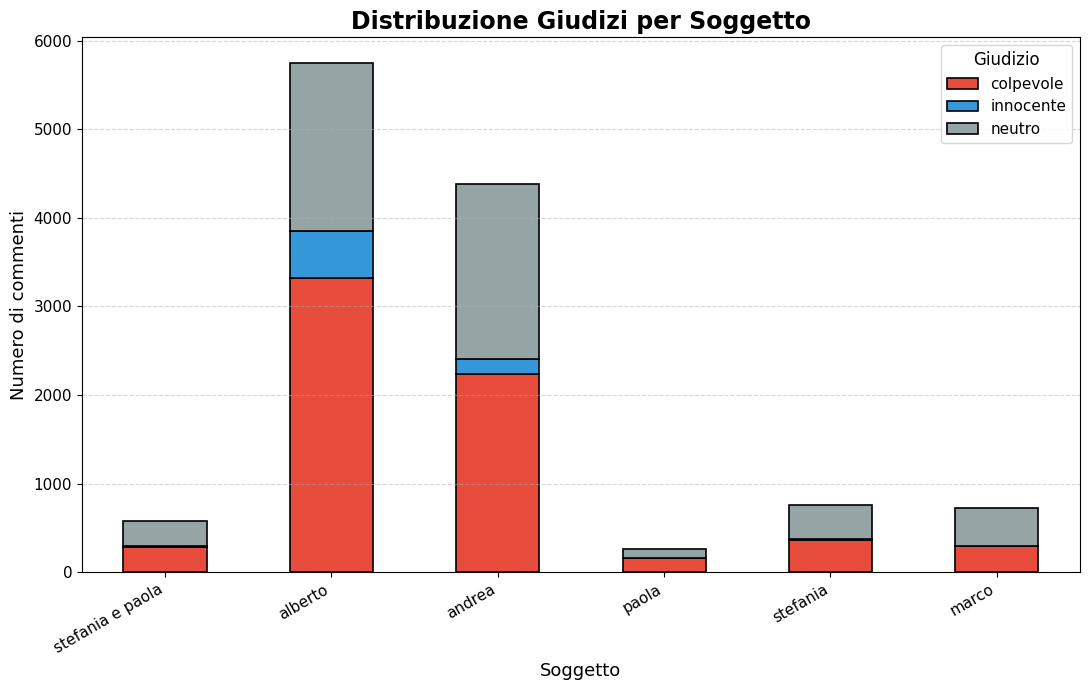

In [12]:
colori = ["#e74c3c", "#3498db", "#95a5a6"] 

ax = df_riepilogo[["colpevole", "innocente", "neutro"]].plot(
    kind="bar",
    stacked=True,
    figsize=(11, 7),
    color=colori,
    edgecolor="black",
    linewidth=1.2
)
plt.title("Distribuzione Giudizi per Soggetto", fontsize=17, fontweight='bold')
plt.ylabel("Numero di commenti", fontsize=13)
plt.xlabel("Soggetto", fontsize=13)
plt.xticks(rotation=30, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title="Giudizio", fontsize=11, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


== Distribuzione Giudizi per Genere ==
           colpevole  innocente  neutro  totale  % colpevole  % innocente  % neutro
femminile        810         29     770    1609        50.34         1.80     47.86
maschile        5857        704    4301   10862        53.92         6.48     39.60


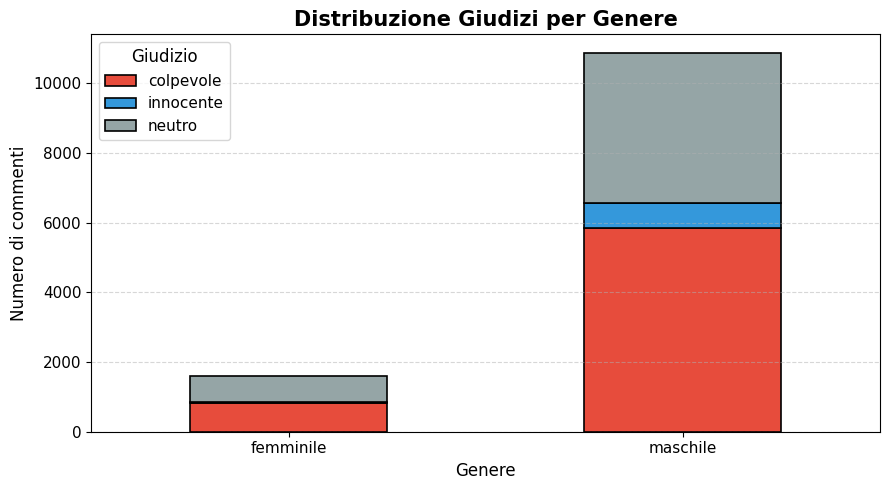

In [ ]:
print("\n== Distribuzione Giudizi per Genere ==")
print(df_genere.round(2).to_string(index=True))

colori = ["#e74c3c", "#3498db", "#95a5a6"]  # rosso, blu, grigio
ax = df_genere[["colpevole", "innocente", "neutro"]].plot(
    kind="bar",
    stacked=True,
    figsize=(9, 5),
    color=colori,
    edgecolor="black",
    linewidth=1.2
)
plt.title("Distribuzione Giudizi per Genere", fontsize=15, fontweight='bold')
plt.ylabel("Numero di commenti", fontsize=12)
plt.xlabel("Genere", fontsize=12)
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title="Giudizio", fontsize=11, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()